# Random Forest

## Import the Dataset

In [58]:
import pandas as pd
df = pd.read_csv("2017 DC LAR.csv",sep="|")

c:\users\spdys\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (2,3,4,5,6,8,9,14,15,16,17,18,19,20,21,22,23,24,25,26,27,29,30,31,32,34,35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Prepare the dataset for random forest

In [59]:
# clean the dataset
rfData = df.copy(deep=True)

colsToKeep = [
    #"Respondent ID",
    "Loan To Income Ratio",
    "Agency Code",
    "Loan Type",
    "Property Type",
    "Loan Purpose",
    "Occupancy",
    #"Loan Amount (000s)",
    #"Preapproval", #sparsely populated
    "Action Type",
    #"Applicant Ethnicity",  #sparsely populated
    #"Co Applicant Ethnicity",  #sparsely populated
    "Applicant Race 1",
    "Co Applicant Race 1",
    "Applicant Sex",
    "Co Applicant Sex",
    #"Applicant Income (000s)",
    #"Purchaser Type",  #appears to indicate whether or not the application was denied
    #"Rate Spread",  #sparsely populated
    "HOEPA Status",
    "Lien Status",
    "Population",
    "Minority Population %",
    "FFIEC Median Family Income",
    "Tract to MSA/MD Income %",
    "Number of Owner-occupied units",
    "Number of 1-to 4-Family units",
    "Small Institution"
]

rfData = rfData[colsToKeep]

rfData = rfData.dropna()

### Fit the random forest model

In [66]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# build feature and label arrays
labels = np.array(rfData["Action Type"])

features = rfData.loc[:, rfData.columns != "Action Type"]
features = pd.get_dummies(features)
feature_labels = list(features.columns)
features = np.array(features)


# train test split
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 0)


# fit the model
class_weight_param = {"Approved": 0.0000001, "Denied": 1}
#class_weight_param = None
clf = RandomForestClassifier(n_jobs=-1, n_estimators=10, random_state=0, class_weight=class_weight_param)
clf = clf.fit(train_features, train_labels)


# make predictions
predicted_labels = clf.predict(test_features)


# view results
results = pd.crosstab(test_labels, predicted_labels, rownames=["Actual"],colnames=["Predicted"])
print(results)


# present accuracy measures
print()
print("Overall Accuracy:","{:.0%}".format(accuracy_score(test_labels, predicted_labels)))
print("Denials Accuracy:","{:.0%}".format(results.loc["Denied","Denied"]/results.loc["Denied"].sum()))

Predicted  Approved  Denied
Actual                     
Approved       2615     744
Denied          277     537

Overall Accuracy: 76%
Denials Accuracy: 66%


In [61]:
results

Predicted,Approved,Denied
Actual,,
Approved,2615,744
Denied,277,537


                                              Feature  Importance
0                                Loan To Income Ratio    0.174043
43       Lien Status_Not applicable (purchased loans)    0.137645
6                       Number of 1-to 4-Family units    0.124183
4                            Tract to MSA/MD Income %    0.109070
1                                          Population    0.101178
2                               Minority Population %    0.096674
5                      Number of Owner-occupied units    0.094940
36                               Applicant Sex_Female    0.010356
37                                 Applicant Sex_Male    0.010048
7                                   Small Institution    0.009617
45                Lien Status_Secured by a first lien    0.008980
13  Agency Code_Office of the Comptroller of the C...    0.008544
9   Agency Code_Department of Housing and Urban De...    0.008222
11           Agency Code_Federal Reserve System (FRS)    0.008188
8   Agency

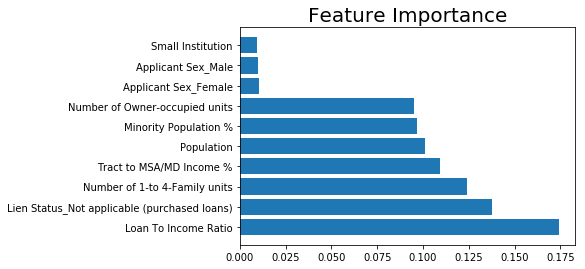

In [67]:
d = {'Feature':feature_labels, 'Importance':clf.feature_importances_}
feature_importance = pd.DataFrame(d)
feature_importance = feature_importance.sort_values(by=["Importance"], ascending=False)
print(feature_importance)

from matplotlib import pyplot as plt
plt.barh(feature_importance["Feature"][0:10],feature_importance["Importance"][0:10])
plt.title("Feature Importance",fontsize=20)
plt.show()

## Analysis

#### Results
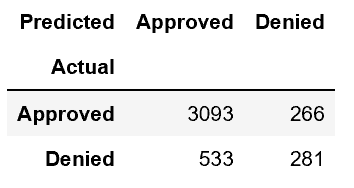

#### Accuracy Measures
- Overall Accuracy: 81% (Roughly the % of "Approved" loans observed in the dataset.
- Denials Accuracy: 35%

#### Accuracy Analysis
- Classes are unbalanced.
- Accuracy is largely based on predicting a high number of approvals.  Unfortunately, that doesn't present profound insight about the data.
- Model has low accuracy predicting the rare "Denied" class.

#### Feature Importance
- Lending at its basic:  Can the borrower pay me back?  If they do not pay me back, how can I recover what I paid for?  Hence, I would have expected income ratio and lien status to be first two features.
- It is comforting to see the model found Loan to Income as the most important feature, and for the importance to be so much higher than the next feature.
- Worringly, saw many features about the neighborhood before we saw anything about lien status.
- Minority Population %; Tract to MSA/MD Income %; Number of Owner-occupied units; Population; Number of 1-to 4-Family units 
- The dataset is dominated by features about the neighborhood, so you would expect to see them.
- The newly enacted legislation on institution reporting exemption is low importance. 

#### Hyperparameters
- Accuracy changes very little with n_estimators=10000 (vs the default of 10)
- Interesting: with n_estimators=3 consistently achieved higher Denial accuracy (+2-6%). While at n_estimators=2, achieved siginficantly lower Denial accuracy (as much as -13%).
- Properly handle the unbalanced nature of the classification.  Using class_weight did result in higher accuracy of predicted denials as seen below.  This also boosted the importance of the Loan to Income ratio.  Denials Accuracy rose dramatically to 66%; while Overall Accuracy fell just to 76%.  The feature importance results exhibited interesting changes with the class_weight setting.  While Loan Amount to Income Ratio remained the top feature, lien status with the value of "purchased loan" moved up dramatically.
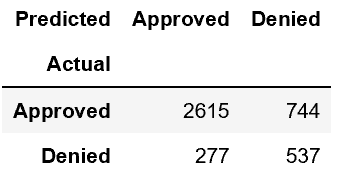

## Example Tree Visualization

In [63]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot

# Pull out one tree from the forest
tree = clf.estimators_[0]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_labels, max_depth=4, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')

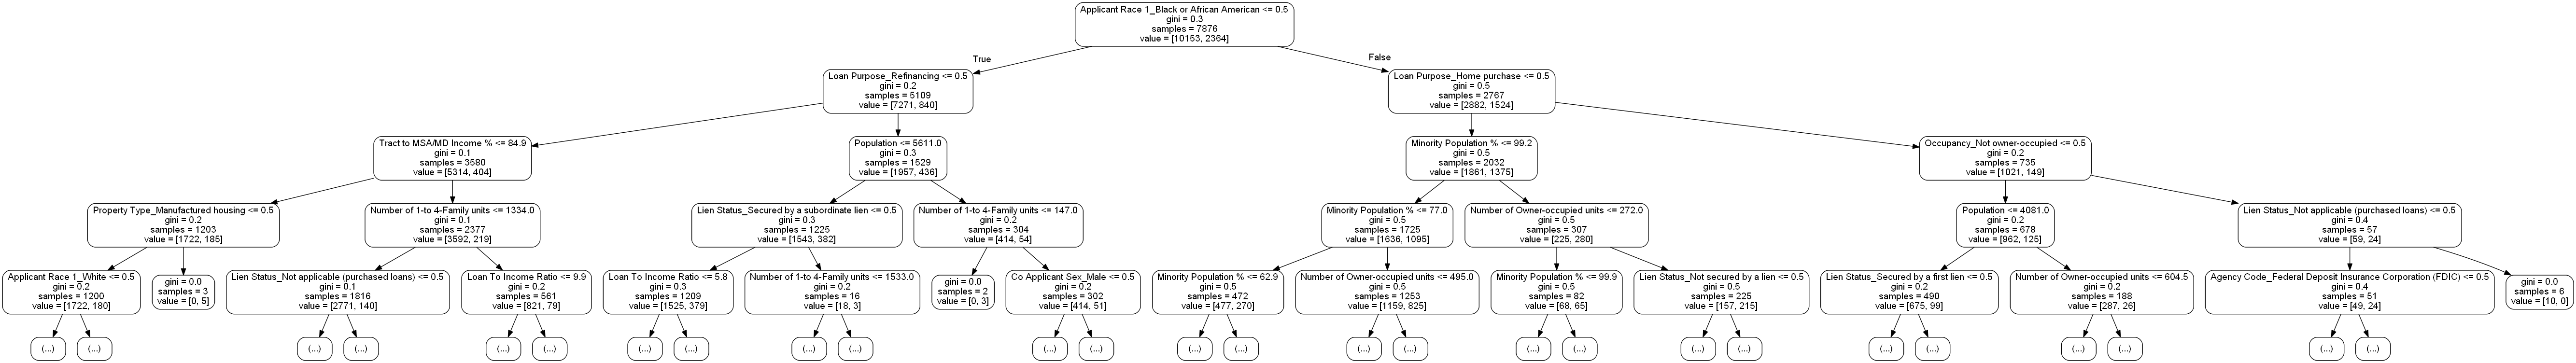